In [2]:
import torch
from torch import nn

In [3]:
torch.__version__

'2.4.0'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import requests
import zipfile
import pathlib
from pathlib import Path
try:
  import py7zr
except :
  !pip install py7zr
  import py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 20.6 MB/s eta 0:00:00


In [6]:
image_path = Path("/kaggle/working/cifar10")
if image_path.exists():
  print(f"{image_path} already exists")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  print(f"creating {image_path}...")

creating /kaggle/working/cifar10...


In [7]:
train_path = image_path/"train"
test_path = image_path/"test"

In [8]:
with py7zr.SevenZipFile("/kaggle/input/cifar-10/train.7z", mode='r') as train_images:
    train_images.extractall(image_path)
with py7zr.SevenZipFile("/kaggle/input/cifar-10/test.7z", mode='r') as test_images:
    test_images.extractall(image_path) 

In [9]:
import os
def explore_directoris(path):
  for dirpath, dirnames,filenames in os.walk(path):
    print(f"there are {len(dirnames)} directoris and {len(filenames)} files in {dirpath}")
explore_directoris(image_path)

there are 2 directoris and 0 files in /kaggle/working/cifar10
there are 0 directoris and 300000 files in /kaggle/working/cifar10/test
there are 0 directoris and 50000 files in /kaggle/working/cifar10/train


In [10]:
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from PIL import Image
import csv

In [11]:
class customImageFolder(Dataset):
  def __init__(self, root, transform=None,mode="train"):
    self.paths = list(pathlib.Path(root).glob("*.png"))
    self.transform = transform
    self.mode = mode
    if self.mode=="train":
      self.labels = {'id':[],'label':[]}
      file_path = "/kaggle/input/cifar-10/trainLabels.csv"
      with open(file_path, mode='r') as file:
          csv_reader = csv.DictReader(file)
          for row in csv_reader:
              self.labels['id'].append(int(row['id']))
              self.labels['label'].append(row['label'])
      self.classes = sorted(list(set(self.labels['label'])))
      self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

  def load_image(self, index):
    image_path = self.paths[index]
    image = Image.open(image_path)
    image = image.convert("RGB")
    return image

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    image = self.load_image(index)
    if self.mode == "train":
      image_id = int(os.path.splitext(os.path.basename(self.paths[index]))[0])
      class_name = self.labels['label'][self.labels['id'].index(image_id)]
      class_idx = self.class_to_idx[class_name]
      if self.transform:
        image = self.transform(image)
      return image, class_idx

    else:
      if self.transform:
          image = self.transform(image)
      return image

In [15]:
data_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [16]:
data = customImageFolder(train_path, transform=data_transform)

In [22]:
import pandas as pd
label_df = pd.DataFrame(data.labels)
label_df.head(n=20)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


In [19]:
label_df['label'].value_counts()

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

In [23]:
import random
import matplotlib.pyplot as plt
import math
def display_random_images(dataset,classes,n,seed=None):
  if n>10:
    n=10
  if seed:
    torch.manual_seed(seed)
  random_samples_idx = random.sample(range(len(dataset.paths)),n)
  plt.figure(figsize=(50,10))
  for i, id in enumerate(random_samples_idx):
    image, label = dataset[id]
    plt.subplot(n,1,i+1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    title = f"class : {classes[label]} | \n size : {image.permute(1,2,0).shape}"
    plt.title(title,fontdict={'fontsize':8})


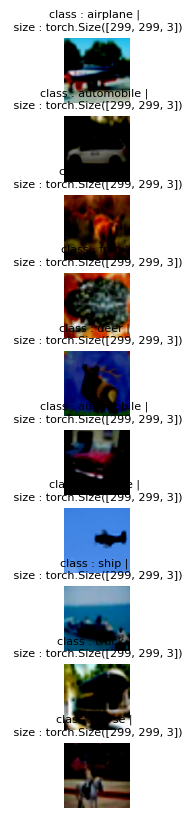

In [24]:
display_random_images(data,data.classes,10,seed=42)

In [25]:
from torch.utils.data import random_split
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

In [30]:
from torch.utils.data import DataLoader
import os
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bd75c12bee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7bd75c12b4f0>)

**Inception V3 from Scratch**

In [ ]:
import torch.nn.functional as F
'''class InceptionBlock(nn.Module):
    def __init__(self, in_channels, f1, f3_in, f3_out, f5_in, f5_out, proj):
        super(InceptionBlock, self).__init__()

        # 1x1 Convolution Branch
        self.branch1x1 = nn.Conv2d(in_channels, f1, kernel_size=1)

        # 1x1 -> 3x3 Convolution Branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, f3_in, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f3_in, f3_out, kernel_size=3, padding=1)
        )

        # 1x1 -> 5x5 Convolution Branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, f5_in, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f5_in, f5_out, kernel_size=5, padding=2)
        )

        # 3x3 Max Pool -> 1x1 Convolution Branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, proj, kernel_size=1)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1x1(x),
            self.branch3x3(x),
            self.branch5x5(x),
            self.branch_pool(x)
        ], dim=1)


class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxiliaryClassifier, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x




class InceptionV3(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True):
        super(InceptionV3, self).__init__()
        self.aux_logits = aux_logits

        # Initial Conv Layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)

        # Inception Blocks
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        
        if self.aux_logits:
            self.aux_classifier = AuxiliaryClassifier(512, num_classes)

        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        # Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = self.inception4a(x)
        
        aux_output = None
        if self.training and self.aux_logits:
            aux_output = self.aux_classifier(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        if self.training and self.aux_logits:
            return x, aux_output
        return x'''

**Pretrained Inception V3**

In [33]:
import torch.nn as nn
from torchvision import models

# Load the pre-trained Inception V3 model
def get_inception_v3_model(num_classes):
    model = models.inception_v3(pretrained=True)

    # Modify the final fully connected layer to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Modify the auxiliary classifier (if enabled) to match the number of classes
    if model.aux_logits:
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    return model


In [34]:
torch.manual_seed(42)
HIDDEN_UNITS = 10
input_filters = 3
num_classes = 10
model_ = get_inception_v3_model(num_classes)

model_

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [36]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_,input_size=(64,3,299,299))

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [64, 10]                  2,565,386
├─BasicConv2d: 1-1                       [64, 32, 149, 149]        --
│    └─Conv2d: 2-1                       [64, 32, 149, 149]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 149, 149]        64
├─BasicConv2d: 1-2                       [64, 32, 147, 147]        --
│    └─Conv2d: 2-3                       [64, 32, 147, 147]        9,216
│    └─BatchNorm2d: 2-4                  [64, 32, 147, 147]        64
├─BasicConv2d: 1-3                       [64, 64, 147, 147]        --
│    └─Conv2d: 2-5                       [64, 64, 147, 147]        18,432
│    └─BatchNorm2d: 2-6                  [64, 64, 147, 147]        128
├─MaxPool2d: 1-4                         [64, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [64, 80, 73, 73]          --
│    └─Conv2d: 2-7                       [64, 80, 73, 73]          5,

In [37]:
def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)  # Move data to the specified device (CPU/GPU)

        # Forward pass
        if model.aux_logits:  # Check if auxiliary outputs exist
            y_pred, aux_outputs = model(X)
            loss = loss_fn(y_pred, y) + 0.4 * loss_fn(aux_outputs, y)  # Combine main and auxiliary losses
        else:
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item() * X.size(0)  # Accumulate loss
        y_pred_class = torch.argmax(y_pred, dim=1)
        total_correct += (y_pred_class == y).sum().item()  # Count correct predictions
        total_samples += y.size(0)  # Update total number of samples

    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc


In [38]:
def test_step(model, data_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculations for testing
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)  # Move data to the specified device

            # Forward pass (auxiliary outputs are ignored during evaluation)
            y_pred = model(X)

            # Compute loss only on the main output
            loss = loss_fn(y_pred, y)
            total_loss += loss.item() * X.size(0)  # Accumulate loss

            # Compute accuracy
            y_pred_class = torch.argmax(y_pred, dim=1)
            total_correct += (y_pred_class == y).sum().item()  # Count correct predictions
            total_samples += y.size(0)  # Update total number of samples

    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc


In [42]:
from tqdm.auto import tqdm

def pretrain(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    # Freeze all layers except the final layers
    for param in model.parameters():
        param.requires_grad = False  # Freeze all parameters

    # Unfreeze the final fully connected layer and auxiliary classifier
    for param in model.fc.parameters():
        param.requires_grad = True
    if model.aux_logits:  # Unfreeze auxiliary classifier if it exists
        for param in model.AuxLogits.parameters():
            param.requires_grad = True

    # Track results
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Testing step
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # Logging
        print(f"Epoch: {epoch + 1} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [43]:
torch.manual_seed(42)

# Define the optimizer and filter only the parameters that require gradients
optimizer = torch.optim.Adam(
    params=filter(lambda p: p.requires_grad, model_.parameters()), 
    lr=0.001, 
    weight_decay=1e-4
)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Number of epochs for pretraining
epochs = 5

# Measure training time
from timeit import default_timer as timer
start_time = timer()

# Perform pretraining
results = pretrain(
    model=model_,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device
)

end_time = timer()
print(f"Total pretraining time: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.7499 | Train Acc: 0.8084 | Test Loss: 0.5420 | Test Acc: 0.8177
Epoch: 2 | Train Loss: 0.6999 | Train Acc: 0.8133 | Test Loss: 0.5263 | Test Acc: 0.8231
Epoch: 3 | Train Loss: 0.6758 | Train Acc: 0.8145 | Test Loss: 0.5064 | Test Acc: 0.8299
Epoch: 4 | Train Loss: 0.6728 | Train Acc: 0.8134 | Test Loss: 0.5116 | Test Acc: 0.8252
Epoch: 5 | Train Loss: 0.6544 | Train Acc: 0.8171 | Test Loss: 0.5069 | Test Acc: 0.8273
Total pretraining time: 734.488 seconds


In [44]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results["train_loss"]))
  plt.figure(figsize=(15,7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

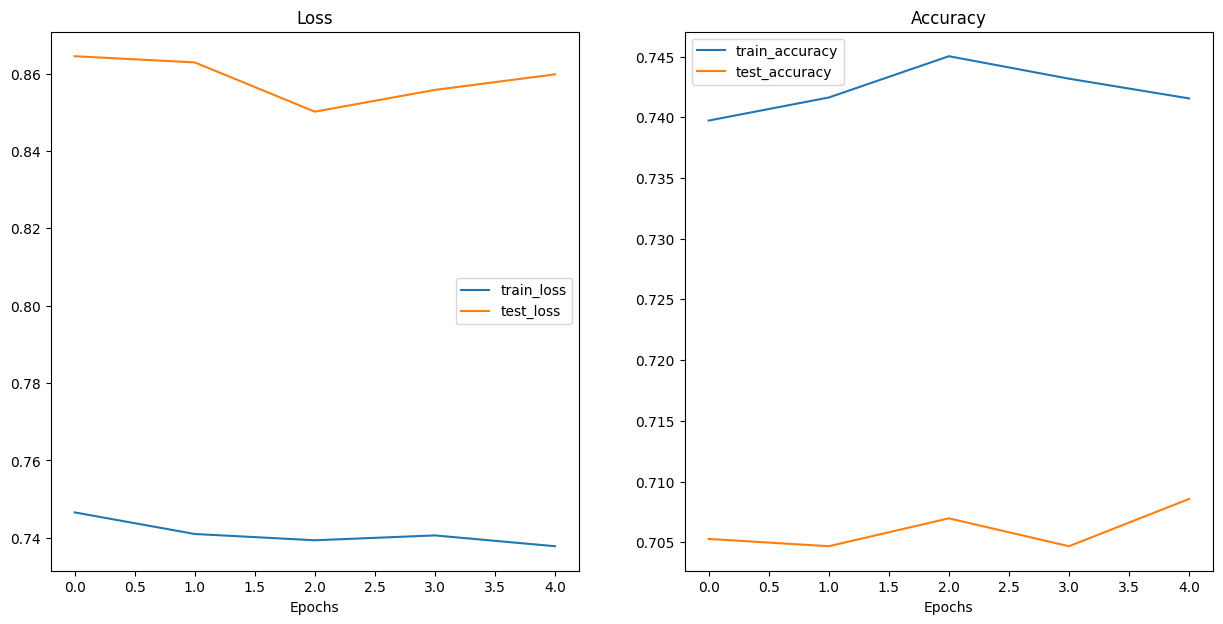

In [53]:
plot_loss_curves(results)

****Its prediction tym!!****

In [45]:
predict_data = customImageFolder(test_path, transform=data_transform,mode="test") 
predict_dataloader = DataLoader(dataset=predict_data,batch_size=1,num_workers=0,shuffle=False) 
predict_dataloader

In [46]:
def predict(model,data,data_loader,class_names,device):
  model.eval()
  prediction = {}
  label = []
  id = []
  with torch.inference_mode():
    for batch, X in tqdm(enumerate(data_loader)):
        X = X.to(device)

        y_pred = model(X)
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        label.append(class_names[y_pred_class])
        id.append(os.path.splitext(os.path.basename(data.paths[batch]))[0])
  prediction = {"id":id,"label":label}
  return prediction


In [ ]:
prediction=predict(model_,predict_data,predict_dataloader,data.classes,device)

0it [00:00, ?it/s]

In [ ]:
import csv
csv_file = "submission.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(prediction.keys())
    writer.writerows(zip(*prediction.values()))
print(f"CSV saved to {csv_file}")

In [ ]:
def display_predicted_images(dataset,prediction,classes,n,seed=None):
  if n>10:
    n=10
  if seed:
    torch.manual_seed(seed)
  random_samples_idx = random.sample(range(len(dataset.paths)),n)
  plt.figure(figsize=(16,8))
  for i, id in enumerate(random_samples_idx):
    image = dataset[id]
    label = prediction["label"][prediction["id"].index(str(id))]
    plt.subplot(1,n,i+1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    title = f"class : {label} | \n size : {image.permute(1,2,0).shape}"
    plt.title(title,fontdict={'fontsize':8})

In [ ]:
display_predicted_images(predict_data,prediction,data.classes,10,seed=None)